予約内容     和泉400つ7902 (リニューアル工事部管理)  和泉581み3701 (リニューアル工事部管理)  \
年度   月度                                                       
2025 8                      144.0                       0.0   
     9                       36.0                     263.0   
     10                     122.0                      15.5   

予約内容     和泉581く9368 (安品ア室管理)  和泉581の6302 (安品ア室管理)  和泉581は5240 (積算部管理)  \
年度   月度                                                                 
2025 8                  89.0                21.00               173.0   
     9                   0.0                92.75               251.0   
     10                  0.0                 0.00               182.0   

予約内容     和泉581み9657 (積算部管理)  和泉581む1869 (積算部管理)  
年度   月度                                          
2025 8                162.0               160.0  
     9                194.0               368.5  
     10               168.0               188.0

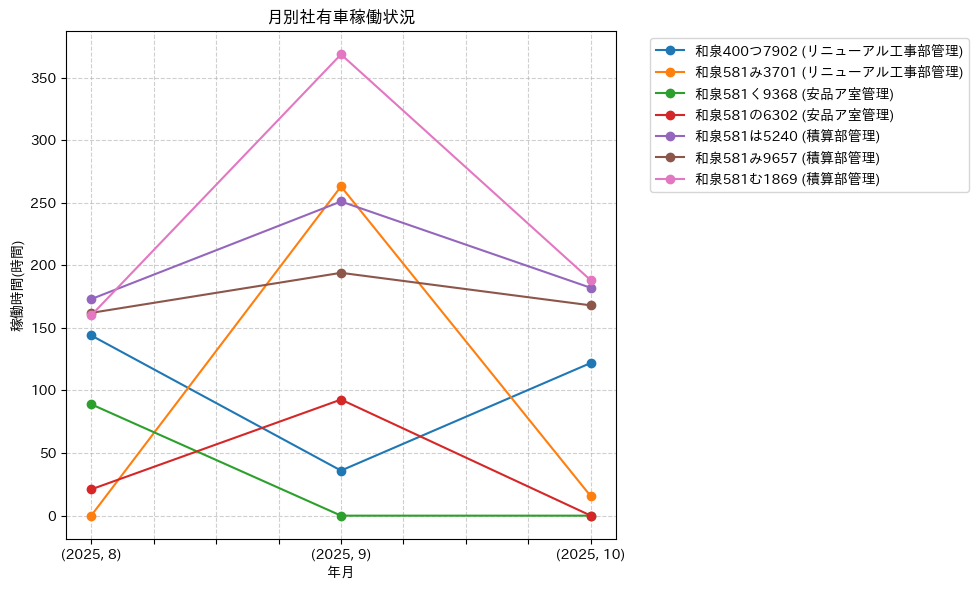

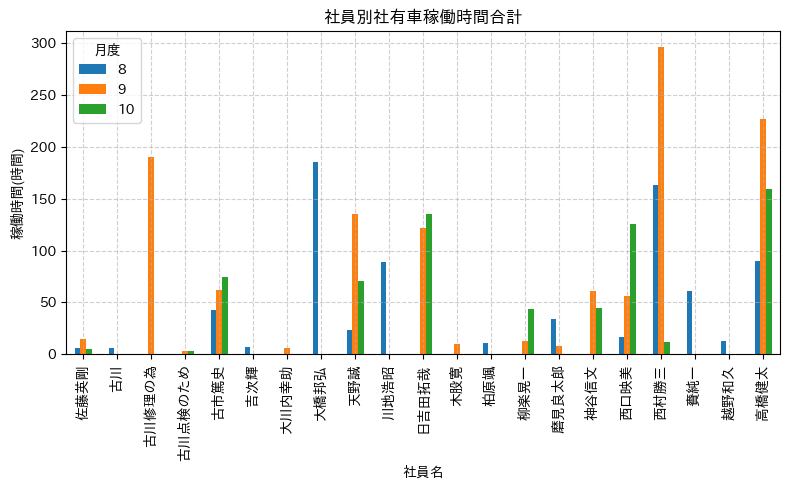

In [23]:
import pandas as pd
from datetime import datetime,date
from glob import glob
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# 各社有車の稼働時間のまとめ

### 目的
## 社員が予約した内容から社有車の稼働時間を算出するための元データとしてまとめる
## 一つのデータフレームにまとめ、重複したデータは削除する。
## 生のデータフレームを返す(return)

today = date.today().strftime('%Y%m%d')

def load_and_combine_reservations():
    """
    指定されたパターンの予約リストCSVファイルを全て読み込み、
    一つのデータフレームに結合して返す。
    結合の過程で重複した行は削除される。
    """

    yoyaku_files = glob('ご予約リスト_*.csv')
    
    df_LIST = []
    df_raw = pd.DataFrame()

    for file in yoyaku_files:
        df_single_file = pd.read_csv(file,encoding = 'shift_jis')
        df_LIST.append(df_single_file)
    df_concat = pd.concat(df_LIST,ignore_index=True)
    df_concat = df_concat.drop_duplicates()
    return df_concat

def yoyaku_list_surgery(df):
    """
    予約データフレームを受け取り、表やグラフ作成にあたって一部整形する。
    """
    df[['予約日','時間範囲_str']]= df['予約日時'].str.split(' ',expand=True)
    df[['開始時刻','終了時刻']]=df['時間範囲_str'].str.split('\r\n~',expand=True)
    df['開始時刻']=pd.to_datetime(df['開始時刻'],format='%H：%M')
    df['終了時刻']=pd.to_datetime(df['終了時刻'],format='%H：%M')
    df['実稼働時間_timedelta']=df['終了時刻']-df['開始時刻']
    total_seconds = df['実稼働時間_timedelta'].dt.total_seconds()
    df['実稼働時間_hour']=total_seconds/3600
    df['名前']=df['名前'].str.replace('　','')
    df['名前']=df['名前'].str.replace(' ','')
    df['予約日']=pd.to_datetime(df['予約日'])
    df['年度']=df['予約日'].dt.year
    df['月度']=df['予約日'].dt.month
    df['曜日']=df['予約日'].dt.day_name()

    replace_rules = {
        '西口':'西口映美',
        '西村':'西村勝三',
        '日吉田':'日吉田拓哉'
    }
    df['名前'] = df['名前'].replace(replace_rules)
    
    return df

def make_report(df):
    report_pivot=pd.pivot_table(df,
                                index=['年度','月度'],
                                columns='予約内容',
                                values='実稼働時間_hour',
                                aggfunc='sum',
                                fill_value=0)
    employee_hour = pd.pivot_table(df,
                                    index='名前',
                                    columns='月度',
                                    values='実稼働時間_hour',
                                    aggfunc='sum',
                                    fill_value=0)
    # employee_hour = df.groupby('名前')['実稼働時間_hour'].sum().sort_values(ascending=True)
    pivot_table = pd.pivot_table(df,
                                 index=['年度', '月度'],
                                 columns='予約内容',
                                 values='実稼働時間_hour',
                                 aggfunc='sum',
                                 fill_value=0)
    # pivot_table = pivot_table['和泉581み9657 (積算部管理)','和泉581は5240 (積算部管理)','和泉581む1869 (積算部管理)','和泉581く9368 (安品ア室管理)','和泉581の6302 (安品ア室管理)','和泉400つ7902 (リニューアル工事部管理)','和泉581み3701 (リニューアル工事部管理)']
    pivot_table.to_excel(f'company_car_usage_report_{today}.xlsx')

    return report_pivot ,employee_hour

def visualize(df_for_plot,employee_hour):
    df_for_plot.plot(figsize=(10,6), style='o-')
    plt.title('月別社有車稼働状況')
    plt.xlabel('年月')
    plt.ylabel('稼働時間(時間)')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'company_car_usage_{today}.png')
    plt.show()
    plt.close()

    employee_hour.plot(figsize=(8,5), kind='bar')
    plt.title('社員別社有車稼働時間合計')
    plt.xlabel('社員名')
    plt.ylabel('稼働時間(時間)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'employee_car_usage_{today}.png')
    plt.show()
    plt.close()
    







df = load_and_combine_reservations()
row_data = yoyaku_list_surgery(df)
report,employee_report = make_report(row_data)
desired_order = ['和泉400つ7902 (リニューアル工事部管理)',
                '和泉581み3701 (リニューアル工事部管理)',
                '和泉581く9368 (安品ア室管理)',
                '和泉581の6302 (安品ア室管理)',
                '和泉581は5240 (積算部管理)',
                '和泉581み9657 (積算部管理)',
                '和泉581む1869 (積算部管理)']
report_reordered = report[desired_order]
display(report_reordered)
visualize(report_reordered,employee_report)








